In [5]:
!nvidia-smi


Tue Dec  5 13:29:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [7]:
pip install tensorflow-addons

  Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


In [40]:
import random
import warnings
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, MaxPool2D, Input
from tensorflow.keras.saving import load_model
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import confusion_matrix, classification_report,f1_score
import os
import pathlib
import shutil
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)  # If using a GPU, enable memory growth

# Install required package
!pip install tensorflow_addons


In [10]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Yp3RK5raZJ7EW8cRulik")
project = rf.workspace("new-workspace-onq0e").project("covid-x-ray-images")
dataset = project.version(1).download("folder")


  Using cached roboflow-1.1.12-py3-none-any.whl (68 kB)
  Using cached certifi-2023.7.22-py3-none-any.whl (158 kB)
  Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Covid-X-ray-Images-1 in folder:: 100%|██████████| 21118/21118 [00:02<00:00, 9648.75it/s] 


In [11]:
rf = Roboflow(api_key="Yp3RK5raZJ7EW8cRulik")
project = rf.workspace("joseph-nelson").project("covid-19-and-pneumonia-scans")
dataset = project.version(1).download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to COVID-19-and-Pneumonia-Scans-1 in folder:: 100%|██████████| 5889/5889 [00:03<00:00, 1906.19it/s]


In [12]:
rf = Roboflow(api_key="Yp3RK5raZJ7EW8cRulik")
project = rf.workspace("umar-farooq").project("classification-kdgyu")
dataset = project.version(1).download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to classification-1 in folder:: 100%|██████████| 12781/12781 [00:05<00:00, 2523.43it/s]


In [13]:
# Define your source and destination directories
source_directories = [
    "/content/Covid-X-ray-Images-1/test/COVID",
    "/content/Covid-X-ray-Images-1/train/COVID",
    "/content/classification-1/train/COVID-19"
]

destination_directory = "/content/combined_covid-19"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Loop through source directories and copy their contents to the destination directory
for source_dir in source_directories:
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_directory, filename)
        shutil.copy(source_path, destination_path)

# Optionally, you can print the number of files copied
file_count = len(os.listdir(destination_directory))
print(f"Combined {file_count} files into {destination_directory}")


Combined 8127 files into /content/combined_covid-19


In [14]:
# Define your source directories
source_directories = [
    "/content/COVID-19-and-Pneumonia-Scans-1/train/healthy",
    "/content/classification-1/train/Normal",
    "/content/Covid-X-ray-Images-1/test/Normal",
    "/content/Covid-X-ray-Images-1/train/Normal"
]

destination_directory = "/content/combined_data_normal"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Loop through source directories and copy their contents to the destination directory
for source_dir in source_directories:
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_directory, filename)
        shutil.copy(source_path, destination_path)

# Optionally, you can print the number of files copied
file_count = len(os.listdir(destination_directory))
print(f"Combined {file_count} files into {destination_directory}")


Combined 16008 files into /content/combined_data_normal


In [15]:
# Define your source directories
source_directories = [
    "/content/COVID-19-and-Pneumonia-Scans-1/train/pneumonia",
    "/content/Covid-X-ray-Images-1/train/Viral_Pneumonia",
    "/content/Covid-X-ray-Images-1/test/Viral_Pneumonia"
]

destination_directory = "/content/combined_data_pneumonia"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Loop through source directories and copy their contents to the destination directory
for source_dir in source_directories:
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_directory, filename)
        shutil.copy(source_path, destination_path)

# Optionally, you can print the number of files copied
file_count = len(os.listdir(destination_directory))
print(f"Combined {file_count} files into {destination_directory}")


Combined 5061 files into /content/combined_data_pneumonia


In [16]:
# Directory paths
combined_covid19_directory = "/content/combined_covid-19"
combined_data_normal_directory = "/content/combined_data_normal"
combined_data_pneumonia_directory = "/content/combined_data_pneumonia"
destination_directory = "/content/data"

# Create the main "data" directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Function to copy a random set of files from a source directory to the destination
def copy_random_files(source_directory, destination_subdirectory, num_files):
    subdirectory_path = os.path.join(destination_directory, destination_subdirectory)
    if not os.path.exists(subdirectory_path):
        os.makedirs(subdirectory_path)

    filenames = os.listdir(source_directory)
    random_files = random.sample(filenames, num_files)
    for filename in random_files:
        source_path = os.path.join(source_directory, filename)
        destination_path = os.path.join(subdirectory_path, filename)
        shutil.copy(source_path, destination_path)

# Copy 5,000 random files from each combined directory to their respective subfolders within the "data" directory
copy_random_files(combined_covid19_directory, "covid19", 5000)
copy_random_files(combined_data_normal_directory, "normal", 5000)
copy_random_files(combined_data_pneumonia_directory, "pneumonia", 5000)

# Optionally, you can print a message indicating the operation was successful
print("Successfully copied 5,000 random files into subfolders in the 'data' directory.")


Successfully copied 5,000 random files into subfolders in the 'data' directory.


In [17]:
pip install split-folders

In [18]:
import splitfolders

#Split data to (Train,val,test)
splitfolders = splitfolders.ratio('/content/data', output="/content/data_split", seed=42, ratio=(.7, .2, .1),group_prefix=None) # default values

Copying files: 15000 files [00:02, 6439.94 files/s]


In [19]:
!pip install tensorflow


In [20]:
from keras.preprocessing.image import ImageDataGenerator

input_shape = (256,256,3)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    horizontal_flip =True,
    vertical_flip = True ,
    fill_mode ='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator = train_datagen.flow_from_directory(
    '/content/data_split/train',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/data_split/val',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
)


test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

test_generator = test_datagen.flow_from_directory(
    '/content/data_split/test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False to maintain the order
)


Found 10500 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [21]:
class_indices = train_generator.class_indices
labels = {value: key for key, value in class_indices.items()}

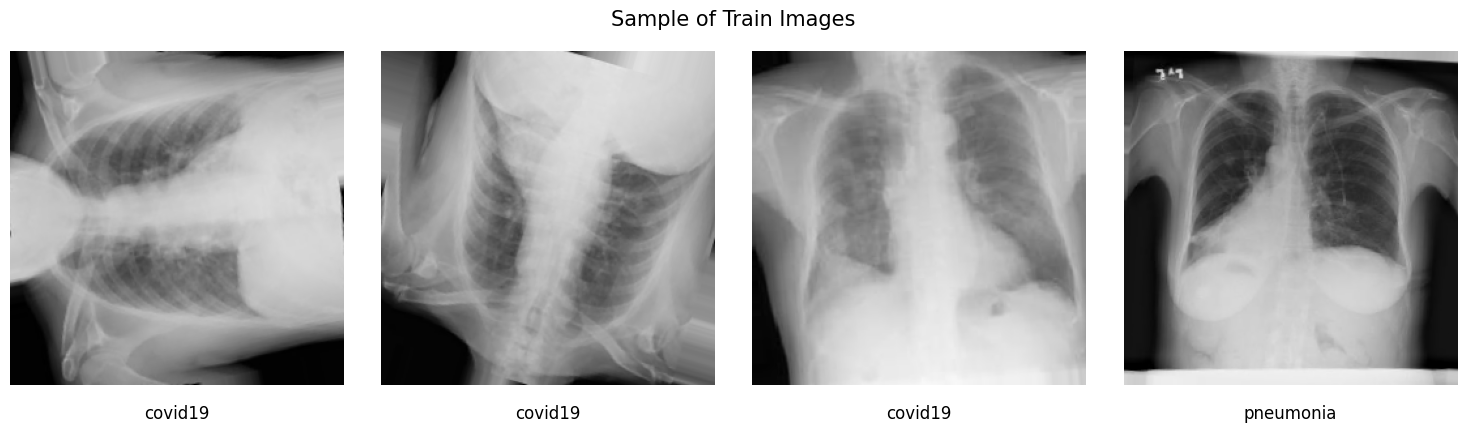

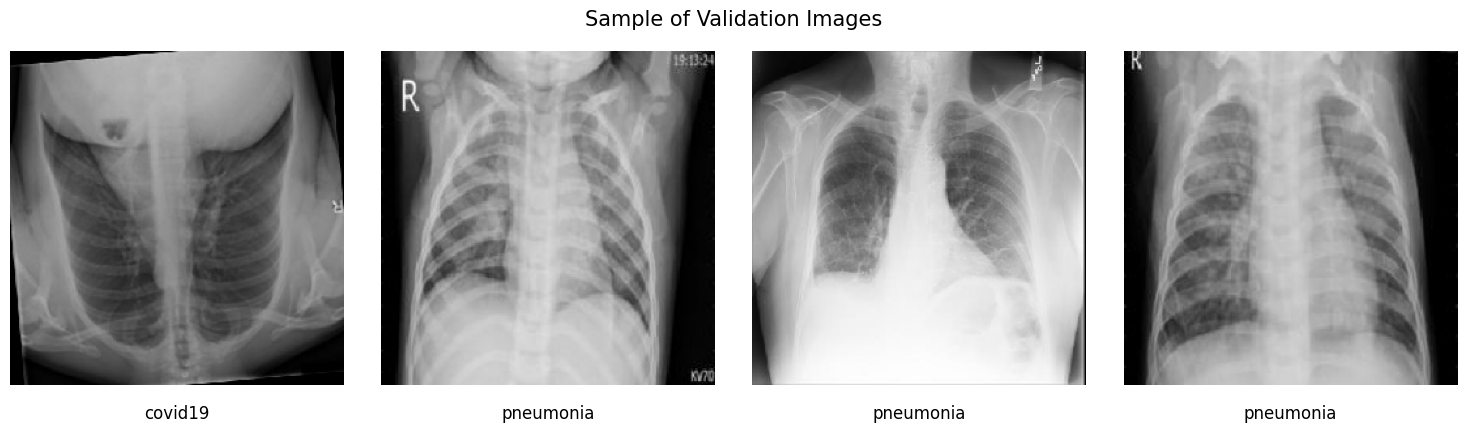

In [22]:
def showthem(subset='train'):
    plt.figure(figsize=(15, 4))
    gen = train_generator  if subset=='train' else validation_generator
    title = 'Sample of Train Images' if subset=='train' else 'Sample of Validation Images'
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        img, label = gen.next()
        plt.imshow(img[0])

        # Add text label
        plt.text(0.5, -0.1, f"{labels[np.argmax(label[0])]}", transform=plt.gca().transAxes, fontsize=12, ha='center')
        plt.axis('off')
    plt.suptitle(title,size=15)
    plt.tight_layout()
    plt.show()

showthem()
showthem("validation")

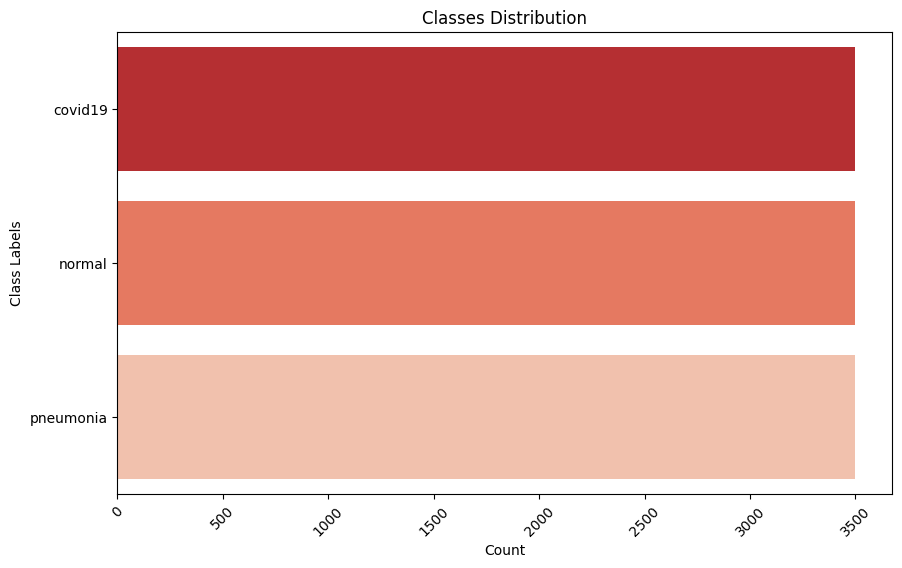

In [23]:
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
counts=[class_counts.tolist().count(i) for i in range(len(class_labels))]

dd = pd.DataFrame({'labels': class_labels, 'counts': counts})
dd = dd.sort_values(by='counts', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='counts', y='labels', data=dd, palette='Reds_r')
plt.xlabel('Count')
plt.ylabel('Class Labels')
plt.title('Classes Distribution')
plt.xticks(rotation=45)
plt.show()

In [24]:
base_model = ResNet101V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

base_model.trainable = True

171317808/171317808 [==============================] - 6s 0us/step


In [25]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                        

In [26]:
def lr_schedule(epoch):
    initial_lr =4.5e-5
    decrease_factor = 1.5
    if epoch >= 8:
        return initial_lr / (decrease_factor * (epoch // 8))
    return initial_lr

lr_scheduler = LearningRateScheduler(lr_schedule)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1 )
early_stopping = EarlyStopping(patience=4, restore_best_weights=True )

In [27]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        F1Score(num_classes=3, average='micro'),'accuracy'
    ]
)

In [28]:
class_labels = train_generator.classes
class_weights = compute_class_weight('balanced' ,classes=np.unique(class_labels), y=class_labels)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.0, 1: 1.0, 2: 1.0}


In [29]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[
        lr_scheduler,
        checkpoint, early_stopping],
    class_weight = class_weight_dict
)

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 0.4710 - f1_score: 0.7967 - accuracy: 0.7967
Epoch 1: val_loss improved from inf to 0.36699, saving model to best_model.h5
329/329 [==============================] - 356s 865ms/step - loss: 0.4710 - f1_score: 0.7967 - accuracy: 0.7967 - val_loss: 0.3670 - val_f1_score: 0.8610 - val_accuracy: 0.8610 - lr: 4.5000e-05
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 0.2476 - f1_score: 0.9020 - accuracy: 0.9020
Epoch 2: val_loss improved from 0.36699 to 0.23238, saving model to best_model.h5
329/329 [==============================] - 285s 866ms/step - loss: 0.2476 - f1_score: 0.9020 - accuracy: 0.9020 - val_loss: 0.2324 - val_f1_score: 0.9130 - val_accuracy: 0.9130 - lr: 4.5000e-05
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 0.2148 - f1_score: 0.9134 - accuracy: 0.9134
Epoch 3: val_loss did not improve from 0.23238
329/329 [==============================] - 269s 818ms/ste

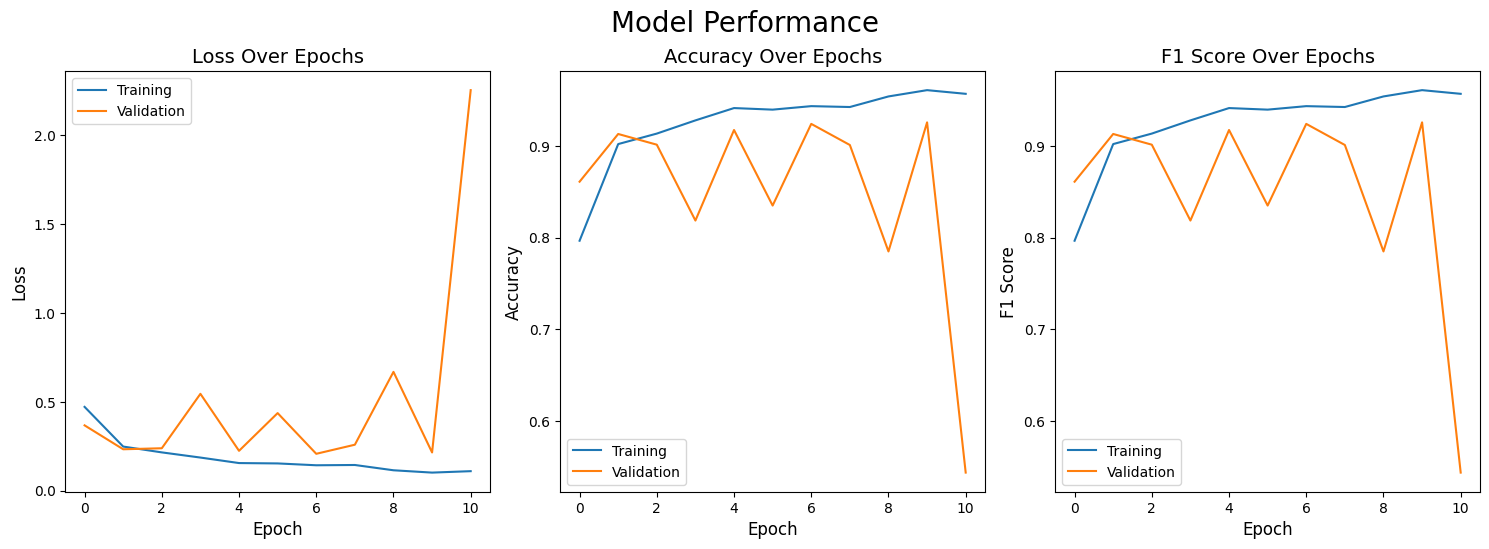

In [30]:
history_dict = history.history
metrics_to_plot = {
    'Loss': ('loss', 'val_loss'),
    'Accuracy': ('accuracy', 'val_accuracy'),
    'F1 Score': ('f1_score', 'val_f1_score')
}

plt.figure(figsize=(15, 10))

for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics_to_plot.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(history_dict[train_metric], label='Training')
    plt.plot(history_dict[val_metric], label='Validation')
    plt.title(f'{metric_name} Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend()

plt.suptitle('Model Performance',size=20)
plt.tight_layout()
plt.show()

In [31]:
model = load_model('best_model.h5')


In [32]:
val_set_final = validation_datagen.flow_from_directory(
    '/content/data_split/val',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3000 images belonging to 3 classes.


In [33]:
num_steps = len(val_set_final )
predictions_val = model.predict_generator(val_set_final, steps=num_steps, verbose=1)

94/94 [==============================] - 19s 185ms/step


In [34]:
val_loss ,val_acc, val_f1 = model.evaluate(val_set_final)


94/94 [==============================] - 21s 194ms/step - loss: 0.2069 - f1_score: 0.9240 - accuracy: 0.9240


In [35]:
true_labels = val_set_final.classes
predicted_labels = np.argmax(predictions_val, axis=1)
predicted_labels

array([0, 1, 0, ..., 2, 1, 2])

In [36]:
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
conf_mat = pd.DataFrame(conf_mat, index=validation_generator.class_indices.keys(), columns=validation_generator.class_indices.keys())

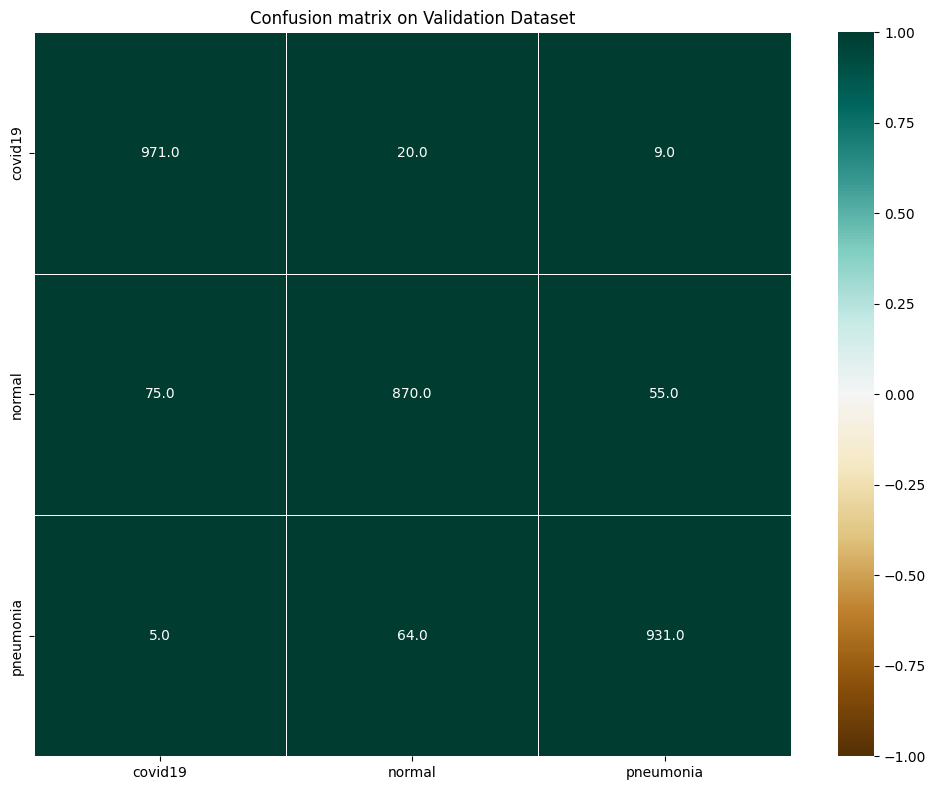

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat,ax=ax ,cmap='BrBG',center=0,vmin=-1,vmax=1,annot=True,fmt='.1f',linewidth=.5)
ax.set_title('Confusion matrix on Validation Dataset')
plt.tight_layout()
plt.show()

In [38]:
test_set_final = test_datagen.flow_from_directory(
    '/content/data_split/test',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1500 images belonging to 3 classes.


47/47 [==============================] - 10s 208ms/step


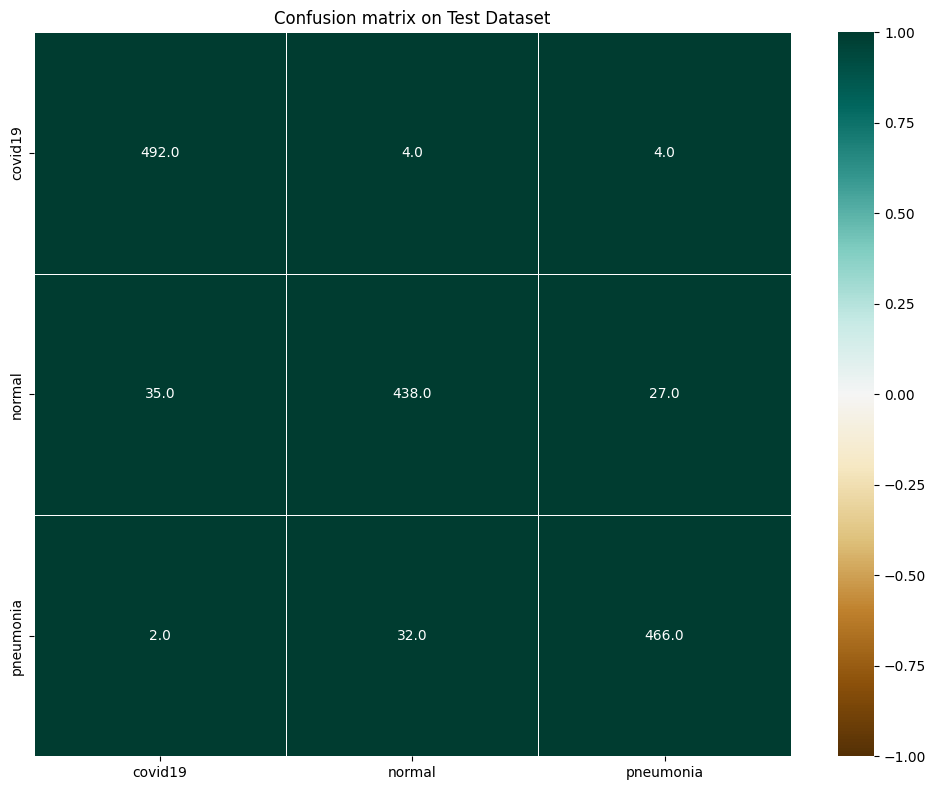

In [41]:
# Calculate loss using model.evaluate
test_loss = model.evaluate(test_set_final)

# Generate predictions for the test dataset
predictions_test = model.predict(test_set_final)

# Calculate the F1-score
true_labels = test_set_final.classes
predicted_labels = np.argmax(predictions_test, axis=1)
test_f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Create a confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)
conf_mat = pd.DataFrame(conf_mat, index=test_set_final.class_indices.keys(), columns=test_set_final.class_indices.keys())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_mat, ax=ax, cmap='BrBG', center=0, vmin=-1, vmax=1, annot=True, fmt='.1f', linewidth=.5)
ax.set_title('Confusion matrix on Test Dataset')
plt.tight_layout()
plt.show()


